In [1]:
import os
import sys
sys.path.insert(0, "/home/aidin/Documents/tum_courses/internship/scarches")

In [2]:
import scarches as sca
import scanpy as sc

## Reading train and validation data

In [3]:
#train = sc.read("./tests/data/train_kang.h5ad",
                #backup_url="https://goo.gl/33HtVh")

In [4]:
train = sc.read("../tests/data/train_kang.h5ad") # Read and load the training dataset (AnnData object)

/home/aidin/.virtualenvs/scgen_env/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/aidin/.virtualenvs/scgen_env/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [5]:
#train = sc.read("../tests/data/train_data.h5ad") # Read and load the training dataset (AnnData object)

Let's remove stimulated CD4T cells from both the training set. This is just for the sake
of this notebook, in practice, you do not need to do this step, just pass the train data

In [6]:
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))]

/home/aidin/.virtualenvs/scgen_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


## Creating and training the model

In [7]:
#scg = scgen.VAEArithKeras(x_dimension= train.shape[1], model_path="./models/test")

In [8]:
network = sca.models.VAEARITH(train_new,
                              z_dimension = 100, 
                              hidden_layer_sizes = [800,800], 
                              dr_rate=0.2)

Encoder Architecture:
	Input Layer in, out: 6998 800
	Hidden Layer 1 in/out: 800 800
	Mean/Var Layer in/out: 800 100
Decoder Architecture:
	First Layer in, out 100 800
	Hidden Layer 1 in/out: 800 800
	Output Layer in/out:  800 6998 



We train the model for 100 epochs

In [9]:
network.train(n_epochs = 100)

Epoch: 0. Train Loss: 0.030320441639156835 Validation Loss: 0.02966980251957735
Epoch: 1. Train Loss: 0.026936510292590216 Validation Loss: 0.026449862129028587
Epoch: 2. Train Loss: 0.02618247545778689 Validation Loss: 0.025673573096766364
Epoch: 3. Train Loss: 0.026045644227485985 Validation Loss: 0.025550614817902585
Epoch: 4. Train Loss: 0.02547877190794126 Validation Loss: 0.024982702368484863
Epoch: 5. Train Loss: 0.024832715830547736 Validation Loss: 0.0244099588262576
Epoch: 6. Train Loss: 0.02474302344522731 Validation Loss: 0.024274174251154704
Epoch: 7. Train Loss: 0.024149002891464783 Validation Loss: 0.023681152706658746
Epoch: 8. Train Loss: 0.02386233332524895 Validation Loss: 0.023406380704978105
Epoch: 9. Train Loss: 0.02371067642944278 Validation Loss: 0.0232412013006799
Epoch: 10. Train Loss: 0.02361172081165774 Validation Loss: 0.02315602699915568
Epoch: 11. Train Loss: 0.02344914160645396 Validation Loss: 0.02299711175300803
Epoch: 12. Train Loss: 0.023376306202733

In [10]:
dir_path = os.path.expanduser(f'/home/aidin/Documents/tum_courses/internship/')
ref_path = f'{dir_path}_ref_model_kang/'
if not os.path.exists(ref_path):
    os.makedirs(ref_path)
network.save(ref_path, overwrite=True)

## Prediction

After training the model you can pass the adata of the cells
you want to perturb. Here we pass unperturbed CD4T cells


In [11]:
unperturbed_cd4t = train[((train.obs["cell_type"] == "CD4T") & (train.obs["condition"] == "control"))]

Here the 'adata' contains the cells that you want estimate the perturbation based on them. we set
"ctrl" to our control labels and "stim" to our stimulated labels. If you apply it in another context
just set "ctrl" :"your_control_label" and "stim":"your_stimulated_label". the returned value is a numpy
matrix of our predicted cells and the second one is the difference vector between our conditions which might
become useful later.

In [12]:
pred, delta = network.predict(adata=train_new, adata_to_predict=unperturbed_cd4t,
                          conditions={"ctrl": "control", "stim": "stimulated"}, cell_type_key="cell_type", condition_key="condition")

In the previous block, the difference between conditions is by default computed using all cells (obs_key="all"). However, some times you might have a rough idea that which groups (e.g. cell types) are close to your cell type of interest. This  might give you more accurate predictions. For example, we can restrict the delta computation only to CD8T and NK cells. We provide dictionary in form of obs_key={"cell_type": ["CD8T", "NK"]} which is telling the model to look at "cell_type" labels in adata (here: train_new) and only compute the delta vector based on "CD8T" and "NK" cells :

>pred, delta = scg.predict(adata=train_new, adata_to_predict=unperturbed_cd4t,
                          conditions={"ctrl": "control", "stim": "stimulated"}, 
                          cell_type_key="cell_type", condition_key="condition",
                         obs_key={"cell_type": ["CD8T", "NK"]})`

## Evaluation of the predcition

In [13]:
pred_adata = sc.AnnData(pred, obs={"condition":["pred"]*len(pred)}, var={"var_names":train.var_names})

Extracting both control and real stimulated CD4T cells from our dataset

In [14]:
CD4T = train[train.obs["cell_type"] =="CD4T"]

Merging predicted cells with real ones 

In [15]:
all_adata = CD4T.concatenate(pred_adata)

### Embedding all real and predicted cells in one PCA plot 

... storing 'condition' as categorical
... storing 'cell_type' as categorical
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


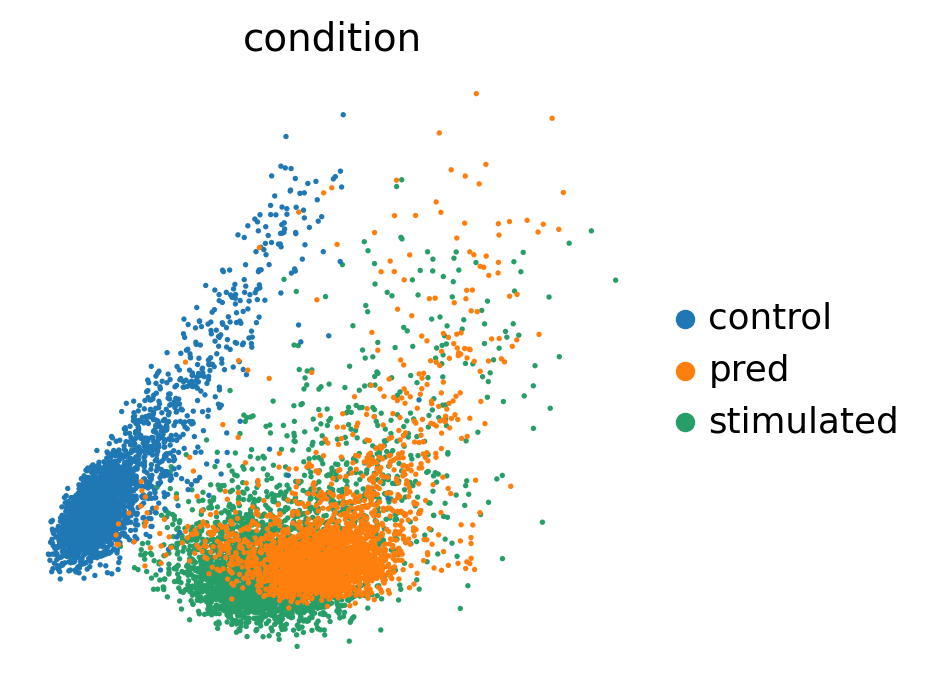

In [16]:
sc.tl.pca(all_adata)
sc.pl.pca(all_adata, color="condition", frameon=False)

### Mean correlation plot

You can also visualize your mean gene expression of your predicted cells vs control cells while
highlighting your genes of interest (here top 10 differentially expressed genes)

In [17]:
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stimulated"]

Trying to set attribute `.uns` of view, copying.


/home/aidin/.virtualenvs/scgen_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


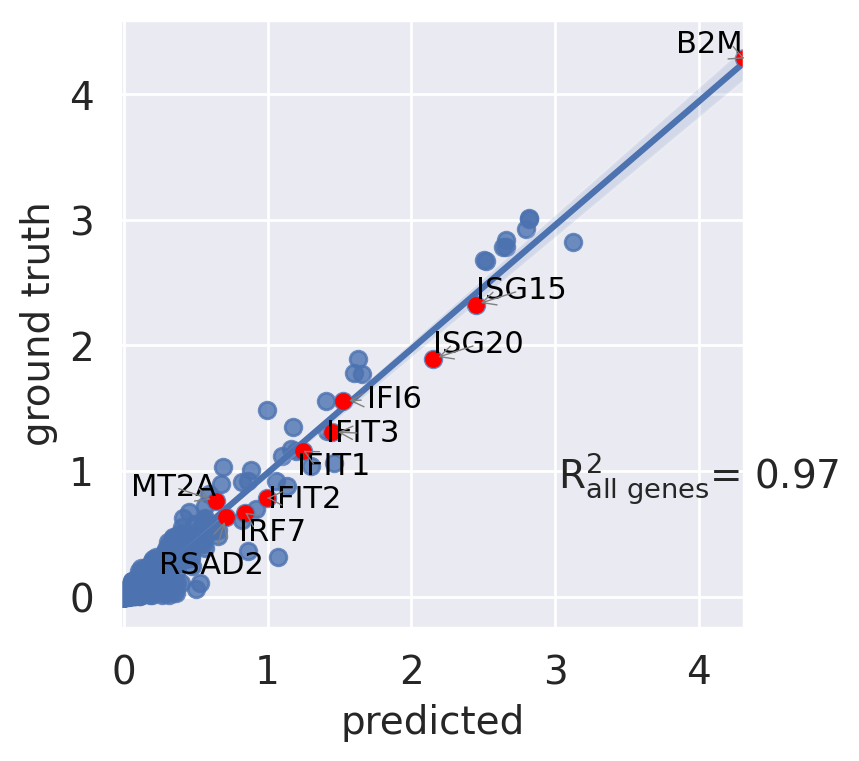

In [18]:
r2_value = sca.plotting.scgen_plotting.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={
                                            "x": "pred", "y": "stimulated"},
                                        gene_list=diff_genes[:10],
                                        labels={"x": "predicted",
                                                "y": "ground truth"},
                                        path_to_save="./reg_mean1.pdf",
                                        show=True,
                                        legend=False)

You can also pass a list of differentially epxressed genes to compute correlation based on them

/home/aidin/.virtualenvs/scgen_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


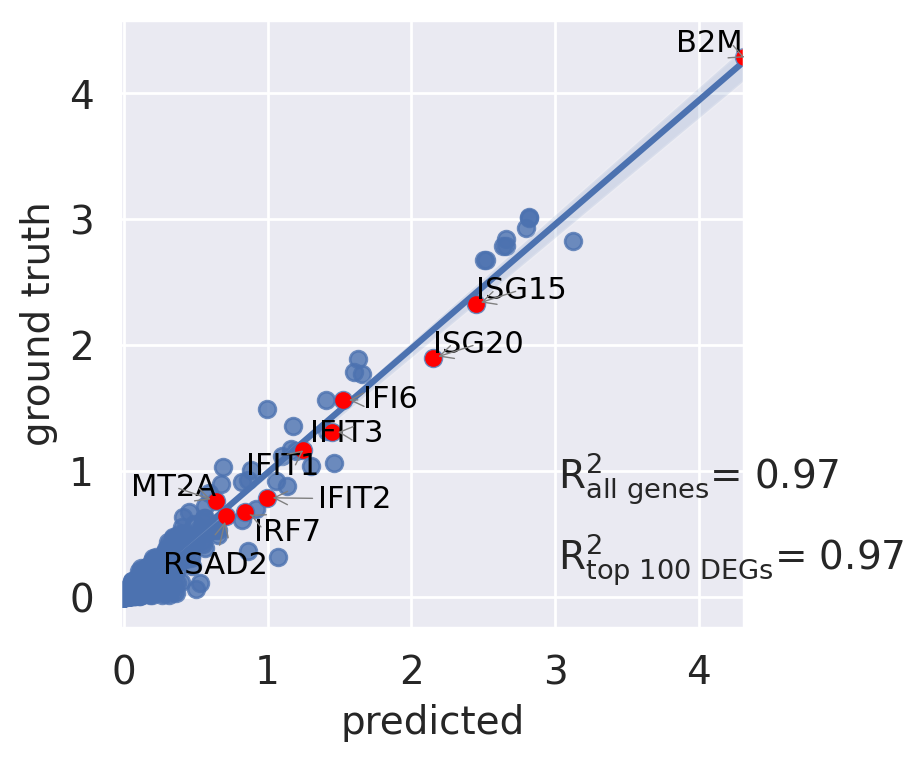

In [19]:
r2_value = sca.plotting.scgen_plotting.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={
                                            "x": "pred", "y": "stimulated"},
                                        gene_list=diff_genes[:10],
                                        top_100_genes= diff_genes,
                                        labels={"x": "predicted",
                                                "y": "ground truth"},
                                        path_to_save="./reg_mean1.pdf",
                                        show=True,
                                        legend=False)

### Violin plot for a specific gene

Let's go deeper and compare the distribution of "ISG15", the top DEG between stimulated and control CD4T cells between predcited and real cells

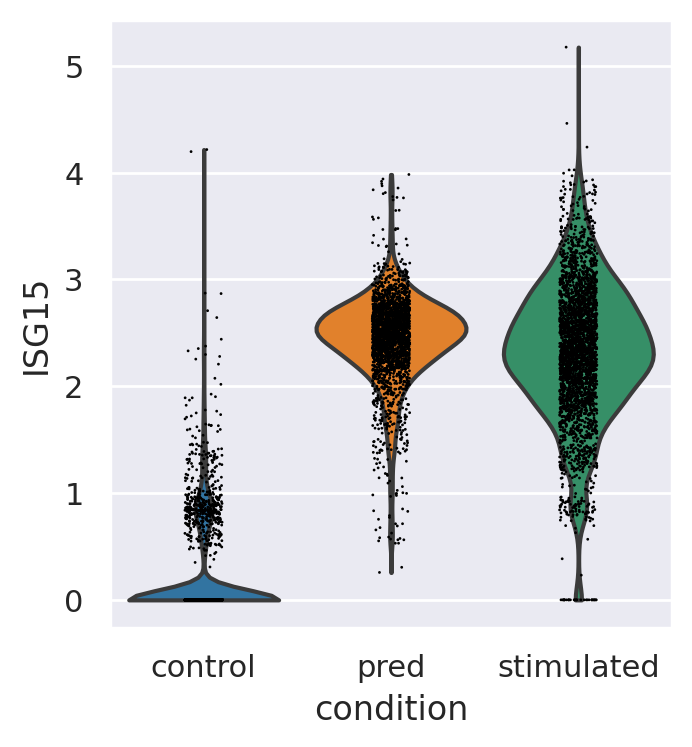

In [20]:
sc.pl.violin(all_adata, keys="ISG15", groupby="condition")